In [1]:
import os.path
import glob
import copy
from collections import namedtuple, OrderedDict, Iterable
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from nblogger import logger

from sumatra.recordstore import DjangoRecordStore as RecordStore
from sumatra.records import Record

from parameters import ParameterSet, Parameter
import mackelab.parameters
import theano_shim as shim
import sinn
import sinn.histories as histories
import sinn.optimize.gradient_descent as gd
import sinn.analyze as anlz
from sinn.analyze.heatmap import HeatMap

import core
import fsgif_model as gif
import gradient_descent as gd_script

%matplotlib inline

2017-10-01 11:09:09,272 - sinn.analyze.stylelib.color_schemes - WARNING - [monochrome_palette]: value was greater than 1 and was clipped.


In [2]:
shim.load_theano()

mgr = core.RunMgr(calc='sgd')

In [3]:
# Load the data and model to fit.
with open("params/gradient_descent-2pop.params") as f:
    param_str = f.read()
params = mgr._params_to_arrays(
    ParameterSet(mackelab.parameters.expand_params(param_str)[0]))
mgr.params = params

data_filename = mgr.get_pathname(params=params.data.params,
                                 subdir=params.data.dir,
                                 suffix=params.data.name,
                                 label='')
input_filename = mgr.get_pathname(params=params.input.params,
                                  subdir=params.input.dir,
                                  suffix=params.input.name,
                                  label='')

data_history = mgr.load(data_filename,
                        cls=getattr(histories, params.data.type).from_raw,
                        calc='activity',
                        recalculate=False)
data_history = core.subsample(data_history, mgr.params.model.dt)
data_history.lock()

input_history = mgr.load(input_filename,
                         cls=getattr(histories, params.input.type).from_raw,
                         calc='input',
                         recalculate=False)
input_history = core.subsample(input_history, mgr.params.model.dt)
input_history.lock()

prior_sampler = core.get_sampler(params.model.prior)

model = core.construct_model(gif, params.model, data_history, input_history,
                             initializer=params.model.initializer)


2017-10-01 11:09:09,819 - fsgif - INFO - Precomputed activity data found.
2017-10-01 11:09:09,876 - fsgif - INFO - Precomputed input data found.


In [4]:
#param_hierarchy = gd_script.get_param_hierarchy(mgr.params)

#datahash = mgr.get_filename(data_params)
#sgdhash = mgr.get_filename(sgd_params)

#run_root = os.path.join(mgr.data_dir, mgr.subdirs['sgd'], 
#                        *[mgr.get_filename(param) for param in param_hierarchy[:-1]])

In [7]:
class RecordView:
    """A read-only interface to a Sumatra record."""
    def __init__(self, record):
        self._record = record
    @property
    def command_line(self):
        return self._record.command_line
    def describe(self, *args, **kwargs):
        return self._record.describe(*args, **kwargs)
    def difference(self, other_record, *args, **kwargs):
        if isinstance(other_record, RecordView):
            other_record = other_record._record
        return self._record.difference(other_record, *args, **kwargs)
    @property
    def script_content(self):
        return self._record.script_content
        

class PlotInfo:
    def __init__(self, plot, records):
        if isinstance(plot, mpl.axes.Axes):
            self.axes = plot
        elif isinstance(plot, Iterable) and isinstance(plot[0], mpl.lines.Line2D):
            # Assume the returned value for plt.plot, whichi is a list of Line2D
            assert(isinstance(line, mpl.lines.Line2D) for line in plot)
            self.axes = plot[0].axes
            # Ensure that all lines have the same axes
            assert(line.axes is self.axes for line in plot)
        if isinstance(records, (Record, RecordView)):
            records = [records]
        assert(isinstance(records[0], Record))
        assert(len(records) == len(self.axes.lines))
        self.records = records
            
class PlotCollection(OrderedDict):
    pass
    #def add(self, plot):
    #    assert(isinstance(plot, PlotInfo))
    #    if plot not in self.plots:
    #        self.plots.append(plot)

In [22]:
class SGDCollection:
    ParamID = namedtuple("ParamID", ['name', 'idx'])
    ParamEvol = namedtuple("ParamEvol", ['axis_label', 'data'])
            
    def __init__(self, db_records='.smt/records', data_root=None, heatmap=None):
        self.data_root = data_root
        self.sgds = []
        self.pathnames = []
        self.refsgd = None
        self.recordstore = RecordStore(db_records)
        if data_root is not None:
            self.load_fits()
        self.heatmap = heatmap
    
    def get_pathname(self, parameter_set):
        param_hierarchy = gd_script.get_param_hierarchy(parameter_set)
        return (os.path.join(mgr.data_dir, mgr.subdirs['sgd'], 
                             *[mgr.get_filename(param) for param in param_hierarchy])
                             + '.sir')
    def get_pathnames(self, parameter_sets):
        pathnames = []
        for paramset in param_sets:
            pathnames.append(self.get_pathname(paramset))
        return pathnames
    
#    def load_fits(self, parameters=None, pathnames=None):
#        if parameters is None and pathnames is None:
#            # Load everything under data_root
#            if self.data_root is not None:
#                pathnames = glob.glob(self.data_root + "/*")
#            else:
#                logger.warning("Nothing to load.")
#                return
#        elif pathnames is None:
#            pathnames = []
#        elif isinstance(pathnames, str):
#            pathnames = [pathnames]
#        elif not isinstance(pathnames, Iterable):
#            raise ValueError("'pathnames' should be a list of path names.")
            
#        param_list = [None] * len(pathnames)
            
#        if parameters is not None:
#            pathnames += self.get_pathnames(pathnames)
#            param_list += parameters

#        for pathname, params in zip(pathnames, param_list):

    def load_fits(self, records):
        
        # Load the fits
        for record in records:
            params = record.parameters
            record.datapath = self.get_pathname(record.parameters)
            
            # Create the SGD from the loaded raw data
            sgdraw, load_path = gd_script.load_latest(mgr, record.datapath)
            sgd = gd.SGD(
                cost=model.loglikelihood,
                model=model,
                optimizer=params.optimizer,
                sgd_file = sgdraw,
                set_params = False  # Have to call verify_transforms first
                    # FIXME: Use default (True) once verify_transforms no longer needed
            )
            if sgd not in self.sgds:
                self.sgds.append( sgd )
                self.sgds[-1].verify_transforms(trust_automatically=True)
                self.sgds[-1].set_params_to_evols()
                #self.pathnames.append(load_path)
                sgd.record = record
            
        if len(self.sgds) > 0:
            self.refsgd = self.sgds[0]
        else:
            logger.warning("No fit files were found.")

    def _original_name(pid):
        orig = self.refsgd._get_nontransformed_param(self.refsgd.get_param(pid.name))
        if orig is None:
            return pid.name
        else:
            return orig.name
    def _original_trace(sgd, pid):
        orig = sgd._get_nontransformed_param(sgd.get_param(pid.name))
        if orig is not None:
            transform = sgd._make_transform(orig, sgd.substitutions[orig][1])
        else:
            orig = sgd.get_param(pid.name)
            transform = lambda x: x
        return transform(sgd.get_evol()[pid.name][(slice(None),) + pid.idx])
            
    def plot_evol_overlay(self, *params):
        """
        *params: One tuple per dimension to plot: (name, idx).
        """
        
        if len(params) == 0:
            logger.warning("You must specify the parameters to plot.")
        
        assert(len(self.sgds) > 0)
        if self.heatmap is not None:
            anlz.plot(self.heatmap)
            for sgd in self.sgds:
                sgd.plot_param_evol_overlay(logL)
        else:
            # Extract the evolution traces corresponding to these parameters
            pids = [ self.ParamID(*p) for p in params ]
            evols = {}
            for pid in pids:
                evols[pid] = self.ParamEvol(
                    self._original_name(pid),
                    [self._original_trace(sgd, pid) for sgd in self.sgds] )
                
            # Plot the traces
            for trace in zip(*[evols[pid].data for pid in pids]):
                if len(trace) != 2:
                    raise NotImplementedError
                plt.plot(trace[0], trace[1])
                plt.scatter(trace[0][0], trace[1][0], s=8, color='red')
                
            # Draw labels
            xlabel = "$" + evols[pids[0]].axis_label + "$"
            ylabel = "$" + evols[pids[1]].axis_label + "$"
            if pids[0].idx is not None:
                xlabel = xlabel[:-1] + "_{{}}".format(pids[0].idx) + "$"
            if pids[1].idx is not None:
                xlabel = xlabel[:-1] + "_{{}}".format(pids[1].idx) + "$"
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
                
            # Plot the ground truth cross
            if self.refsgd.trueparams is not None:
                plt.axvline(self.refsgd.trueparams[self.refsgd.get_param(self._original_name(pids[0]))][pids[0].idx],
                            color='#BBBBBB', zorder=-1)
                plt.axhline(self.refsgd.trueparams[self.refsgd.get_param(self._original_name(pids[1]))][pids[1].idx],
                            color='#BBBBBB', zorder=-1)
                
    def plot_evols(self, ncols=2, colwidth=5, rowheight=3.5, labels=None):       
        # Extract the traces
        traces = OrderedDict()
        records = OrderedDict()
        cost_traces = []
        cost_records = []
        if labels is None:
            labels = []
        label_vals = []
        for sgd in self.sgds:
            cost_traces.append(sgd.get_evol()['logL'])
            cost_records.append(sgd.record)
            label_vals.append([sgd.parameters[label] for label in labels]
                              if hasattr(sgd, 'parameters') else [])
            for p, mask in sgd.fitparams.items():
                for compmask, idx in zip(mask.flat, zip(*np.unravel_index(range(mask.size), mask.shape))):
                    if compmask:
                        trace = sgd.get_evol()[p.name][(slice(None),) + idx]
                        pid = self.ParamID(p.name, idx)
                        if pid in traces:
                            traces[pid].append(trace)
                            records[pid].append(sgd.record)
                        else:
                            traces[pid] = [trace]
                            records[pid] = [sgd.record]
                            
        # Get the MLE estimate
        logL_MLE = max(trace.max() for trace in cost_traces)

        # Setup the plot
        nrows = int(np.ceil(len(traces) / 2)) + 1  # +1 for log L
        plt.figure(figsize=(nrows*rowheight, ncols*colwidth))
        plt.subplot2grid((nrows, ncols), (0,0), colspan=ncols)
        labels = [label.split('.')[-1] for label in labels]
            # Don't print the full parameter hierarchy
        plot_coll = PlotCollection()
        
        # Plot cost trace
        for trace, label_comps in zip(cost_traces, label_vals):
            label = ','.join(label + "=" + str(val)
                             for label, val in zip(labels, label_comps))
            label = label.replace('_', ' ')
            plt.plot(trace - logL_MLE, alpha=0.7, label=label)
        plot_coll['logL'] = PlotInfo(plt.gca(), cost_records)
        plt.ylabel("log L")
        # Calculate the ylim with the first 10% data removed
        initlen = max(int(0.1*len(trace)) for trace in cost_traces)
        plt.ylim(min(trace[initlen:].min() - logL_MLE for trace in cost_traces if len(trace)>initlen),
                 max(trace[initlen:].max() - logL_MLE for trace in cost_traces if len(trace)>initlen))
        if len(label_vals) > 0:
            plt.legend(loc='best')

        # Plot the parameter traces
        for n, (pid, tracelst) in enumerate(traces.items(), start=ncols):
            plt.subplot2grid((nrows, ncols), (n//2, n%2))
            for trace, label_comps in zip(tracelst, label_vals):
                label = ','.join(label + "=" + str(val)
                                 for label, val in zip(labels, label_comps))
                label = label.replace('_', ' ')
                plt.plot(trace, alpha=0.7, label=label)
            plot_coll[pid] = PlotInfo(plt.gca(), records[pid])

            # Draw labels
            ylabel = "$" + pid.name + "$"
            if pid.idx is not None:
                ylabel = ylabel[:-1]
                if '_' in ylabel:
                    # Don't put more than one underscore
                    subscript_idx = ylabel.rfind('_')
                    if ylabel[subscript_idx+1] == '{':
                        ylabel = ylabel[:ylabel.rfind('}')]
                            # Closing bracket will be added below
                    else:
                        ylabel = ylabel[:subscript_idx+1] + '{' + ylabel[subscript_idx+1:]
                else:
                    ylabel += '_{'
                ylabel += ','.join(str(c) for c in pid.idx) + "}$"
            plt.ylabel(ylabel)

            # Plot the ground truth cross
            if self.refsgd.trueparams is not None:
                plt.axhline(self.refsgd.trueparams[self.refsgd.get_param(pid.name)][pid.idx],
                            color='#BBBBBB', zorder=-1)
                
            # Plot the legend
            #if len(label_vals) > 0:
            #    plt.legend(loc='best')
            
        return plot_coll

In [9]:
def param_diff(params1, params2, name1="", name2=""):
    keys1, keys2 = set(params1.keys()), set(params2.keys())
    if keys1 != keys2:
        print("The parameter sets {} and {} do not share the following keys: {}"
              .format(name1, name2, keys1.symmetric_difference(keys2)))
    def diff_vals(val1, val2):
        if isinstance(val1, np.ndarray) or isinstance(val2, np.ndarray):
            return (val1 != val2).any()
        else:
            return val1 != val2
    for key in keys1.intersection(keys2):
        if isinstance(params1[key], ParameterSet):
            if not isinstance(params2[key], ParameterSet):
                print("Key '{}' is parameter set only for {}."
                      .format(key, name1))
            else:
                param_diff(params1[key], params2[key],
                           name1 + "." + key, name2 + "." + key)
        elif isinstance(params2[key], ParameterSet):
            print("Key '{}' is parameter set only for {}."
                  .format(key, name2))
        elif type(params1[key]) != type(params2[key]):
            print("The following values have different type:\n"
                  "  {}.{}: {} ({})\n  {}.{}: {} ({})"
                  .format(name1, key, params1[key], type(params1[key]),
                          name2, key, params2[key], type(params2[key])))
        elif diff_vals(params1[key], params2[key]):
            print("The parameter sets {} and {} differ on key {}.\n"
                  "  {}.{}: {}\n  {}.{}: {}"
              .format(name1, name2, key, 
                      name1, key, params1[key],
                      name2, key, params2[key]))

# 2 parameter fit: $w_{00}$, $τ_{m,1}$

The same 2 parameter fit I sent on Tuesday.

In [14]:
param2_hierarchy = copy.deepcopy(param_hierarchy)
data_params = param2_hierarchy[0]
logL_params = ParameterSet({
    "data": copy.deepcopy(data_params.data),
    "input": copy.deepcopy(data_params.input),
    "model": copy.deepcopy(data_params.model),
    "param1": {"name": "w",
               "idx": (0,0),
               "range_desc": ("lin", -0.5, 1)},
    "param2": {"name":"τ_m",
               "idx": (1,),
               "range_desc": ("log", 0.002, 0.07)},
    "fineness": (25, 3),
    "burnin": 10.0,
    "datalen": 4.0,
    "processes": 1,
    "theano": True
    })
data_params.model.initializer = 'silent'
param2_hierarchy[1].fitmask.w = np.array([[True, False], [False, False]])
logL_params.datalen = 8.0
logL_params.model.initializer = "stationary"
logL_params.data.params.initializer = "stationary"
if 'prior' in logL_params.model:
    del logL_params.model['prior']

In [9]:
logL = mgr.load(mgr.get_pathname(logL_params, subdir=mgr.subdirs['logL_sweep']),
                HeatMap.from_raw)
logL.set_floor(logL.max() - 100)

In [17]:
run_root = os.path.join(mgr.data_dir, mgr.subdirs['sgd'], 
                        *[mgr.get_filename(param) for param in param2_hierarchy[:-1]])

In [28]:
sgd_2param = SGDCollection(os.path.join(run_root, "w00_tau1"), heatmap=logL)

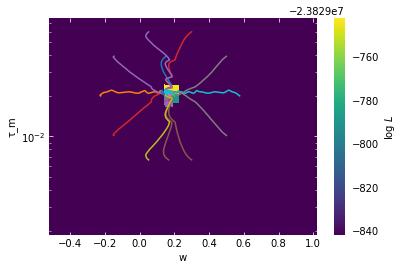

In [30]:
sgd_2param.plot_evols()

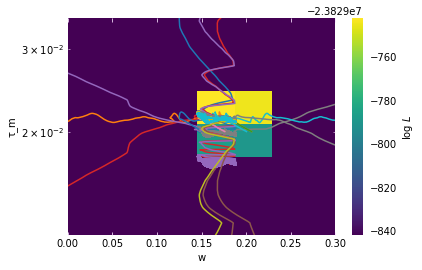

In [31]:
sgd_2param.plot_evols()
    
plt.xlim((0, 0.3))
plt.ylim((0.012, 0.035))
None

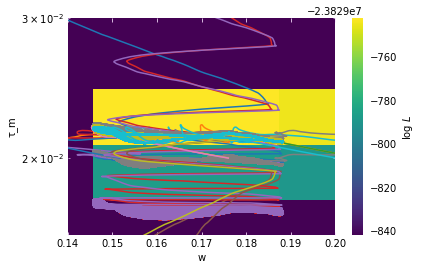

In [33]:
sgd_2param.plot_evols()
    
plt.xlim((0.14, 0.20))
plt.ylim((0.016, 0.03))
None

# 5 parameter fit: $\mathbf{w}$, $τ_{m,1}$

Here we've unclamped the entire connectivity matrix $\mathbf{w} = \begin{pmatrix} w_{00} & w_{01} \\ w_{10} & w_{11} \end{pmatrix}$. One membrane time constant, $τ_{m,1}$, is also unclamped as above. I chose 135 initial parameters, uniformly distributed on a 5-d ellipsoid centered on the true parameters.

## Original

In [8]:
# Old data
mgr.params.model.initializer = 'silent'
mgr.params.datalen = 8.0
mgr.params.fitmask.c = False
mgr.params.fitmask.w = np.array([[True, False], [False, False]])
mgr.params.fitmask.τ_m = np.array([False, True])

In [8]:
param_hierarchy = gd_script.get_param_hierarchy(mgr)

run_root = os.path.join(mgr.data_dir, mgr.subdirs['sgd'], 
                        *[mgr.get_filename(param) for param in param_hierarchy[:-1]])

In [9]:
sgd_5param = SGDCollection(os.path.join(run_root))

2017-09-25 13:22:18,613 - fsgif - INFO - Precomputed sgd data found.
2017-09-25 13:22:18,648 - fsgif - INFO - Precomputed sgd data found.
2017-09-25 13:22:18,684 - fsgif - INFO - Precomputed sgd data found.
2017-09-25 13:22:18,719 - fsgif - INFO - Precomputed sgd data found.
2017-09-25 13:22:18,758 - fsgif - INFO - Precomputed sgd data found.
2017-09-25 13:22:18,777 - fsgif - INFO - Precomputed sgd data found.
2017-09-25 13:22:18,795 - fsgif - INFO - Precomputed sgd data found.
2017-09-25 13:22:18,811 - fsgif - INFO - Precomputed sgd data found.
2017-09-25 13:22:18,828 - fsgif - INFO - Precomputed sgd data found.
2017-09-25 13:22:18,847 - fsgif - INFO - Precomputed sgd data found.
2017-09-25 13:22:18,864 - fsgif - INFO - Precomputed sgd data found.
2017-09-25 13:22:18,880 - fsgif - INFO - Precomputed sgd data found.
2017-09-25 13:22:18,896 - fsgif - INFO - Precomputed sgd data found.
2017-09-25 13:22:18,913 - fsgif - INFO - Precomputed sgd data found.
2017-09-25 13:22:18,932 - fsgif - 

In [86]:
#sgd_5param.plot_evols(('w', (0,0)), ('logτ_m', (1,)))

In [87]:
#sgd_5param.plot_evols(('w', (0,0)), ('w', (0,1)))

In [88]:
#sgd_5param.plot_evols(('w', (1,0)), ('w', (1,1)))

In [245]:
#############
self = sgd_5param
def original_name(pid):
    orig = self.refsgd._get_nontransformed_param(self.refsgd.get_param(pid.name))
    if orig is None:
        return pid.name
    else:
        return orig.name
#############

In [246]:
traces = OrderedDict()
cost_traces = []
for sgd in self.sgds:
    cost_traces.append(sgd.get_evol()['logL'])
    for p, mask in sgd.fitparams.items():
        for compmask, idx in zip(mask.flat, zip(*np.unravel_index(range(mask.size), mask.shape))):
            if compmask:
                trace = sgd.get_evol()[p.name][(slice(None),) + idx]
                pid = ParamID(p.name, idx)
                if pid in traces:
                    traces[pid].append(trace)
                else:
                    traces[pid] = [trace]

We first plot the evolution of each parameter. We see that for most initialization conditions, the traces converge to the same value, which we can reasonably presume is the MLE. We normalized the log likelihoods by substracting the log likelihood of the MLE.

In [247]:
endvals = np.array([trace[-1] for trace in cost_traces])
outliers = [i for i, val in enumerate(endvals) if val < endvals.max() + np.log(0.1)]
logL_MLE = endvals.max()
#print(len(endvals), len(endvals) - len(outliers))

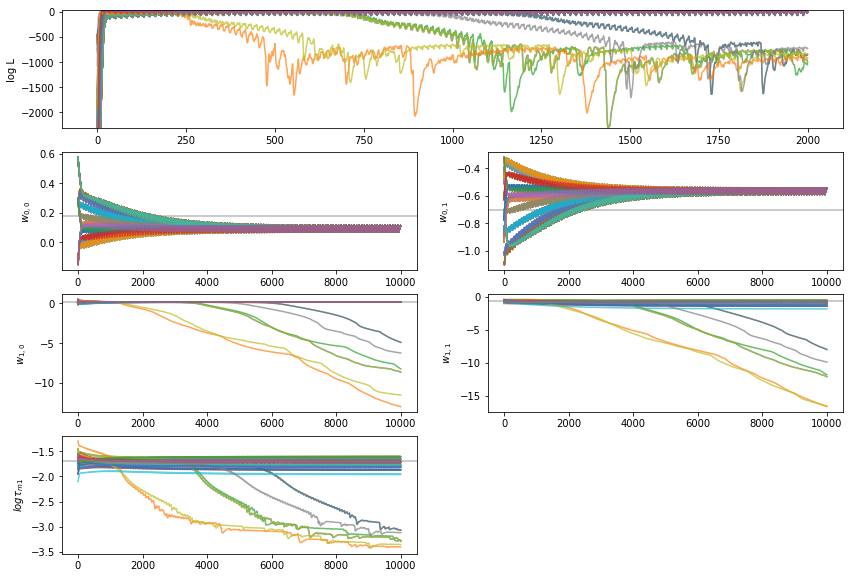

In [248]:
rowheight = 3.5
colwidth = 5
ncols = 2
nrows = int(np.ceil(len(traces) / 2)) + 1  # +1 for log L

plt.figure(figsize=(nrows*rowheight, ncols*colwidth))
plt.subplot2grid((nrows, ncols), (0,0), colspan=ncols)
for trace in cost_traces:
    plt.plot(trace - logL_MLE, alpha=0.7)
plt.ylabel("log L")
#plt.ylabel('log(-log L)')
# Calculate the ylim with the first 10% data removed
initlen = int(0.1*len(cost_traces[0]))
plt.ylim(min(trace[initlen:].min() - logL_MLE for trace in cost_traces),
         max(trace[initlen:].max() - logL_MLE for trace in cost_traces))

for n, (pid, tracelst) in enumerate(traces.items(), start=ncols):
    plt.subplot2grid((nrows, ncols), (n//2, n%2))
    for trace in tracelst:
        plt.plot(trace, alpha=0.7)

    # Draw labels
    ylabel = "$" + pid.name + "$"
    if pid.idx is not None:
        ylabel = ylabel[:-1]
        if '_' in ylabel:
            # Don't put more than one underscore
            subscript_idx = ylabel.rfind('_')
            if ylabel[subscript_idx+1] == '{':
                ylabel = ylabel[:ylabel.rfind('}')]
                    # Closing bracket will be added below
            else:
                ylabel = ylabel[:subscript_idx+1] + '{' + ylabel[subscript_idx+1:]
        else:
            ylabel += '_{'
        ylabel += ','.join(str(c) for c in pid.idx) + "}$"
    plt.ylabel(ylabel)
    
    # Plot the ground truth cross
    if sgd_5param.refsgd.trueparams is not None:
        plt.axhline(self.refsgd.trueparams[self.refsgd.get_param(pid.name)][pid.idx],
                    color='#BBBBBB', zorder=-1)

Let's define $\log \bar{L}$ as the final log likelihood (i.e. after 10&nbsp;000 steps), and say that if a fit terminates with a $log \bar{L}$ that is within 1 order of the MLE, than it is consistent with it. 113 (out of 135) traces satisfy this criteria, and for 101 of them the associated probability is within 5%.

Mathematically, we set the criteria for consistency as $\log \bar{L} - \max(\log \bar{L}) > \log 0.1 \approx -2.3$.

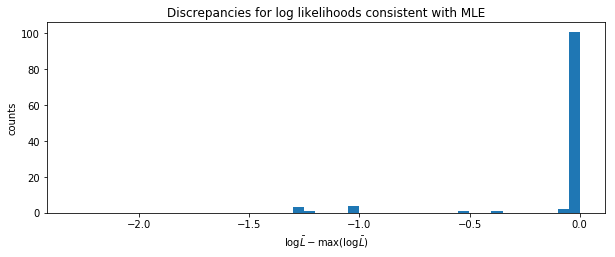

In [253]:
plt.figure(figsize=(10,3.5))
plt.hist([val - logL_MLE for i, val in enumerate(endvals) if i not in outliers],
         bins=np.linspace(np.log(0.1), 0, 47))
plt.ylabel("counts")
plt.xlabel(r"$\log \bar{L} - \max(\log \bar{L})$")
plt.title("Discrepancies for log likelihoods consistent with MLE")
None

Among the 22 outliers, another 14 are somewhat close to the MLE (indicated below by the gray line), leaving 8 traces that are really off the mark.

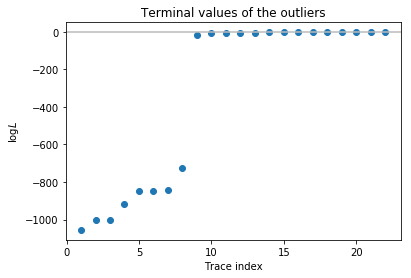

In [259]:
nouts = len(outliers)
plt.scatter(np.arange(1, nouts+1), np.sort(endvals[outliers]) - logL_MLE)
plt.axhline(0, color='#BBBBBB')
plt.title("Terminal values of the outliers")
plt.ylabel(r"$\log L$")
plt.xlabel("Trace index")
None

These 8 traces are those we see fall off in the first plot. The reason we only see 6 traces in the original is because there are two strongly overlapping pairs; we can see this by plotting the 8 outlier traces and cascading them with different offsets.

In [288]:
true_outliers = np.array([i for i in outliers if endvals[i] - logL_MLE < -100])
outlier_traces = OrderedDict(
    (pid, [trace for i, trace in enumerate(tracelist) if i in true_outliers])
    for pid, tracelist in traces.items()
)

In [270]:
init_vals = np.array([[trace[0] for trace in tracelist] for tracelist in outlier_traces.values()])
trace_order = init_vals[0].argsort()
sorted_init_vals = init_vals[:,trace_order]

In [285]:
true_outliers

[0, 1, 40, 62, 78, 81, 108, 127]

In [289]:
true_outliers[trace_order]

array([  1,  78,   0,  40,  62,  81, 108, 127])

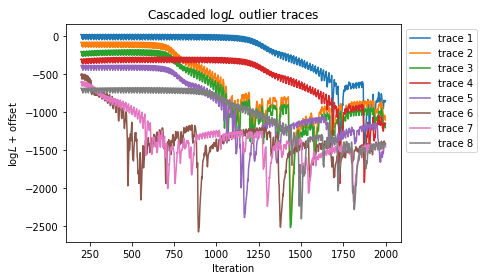

In [293]:
ysep = 100
xarr = np.arange(initlen, max(len(trace) for trace in cost_traces))
for n, i in enumerate(true_outliers[trace_order]):
    plt.plot(xarr, cost_traces[i][initlen:] - logL_MLE - n*ysep,
             label="trace {}".format(n+1))
#plt.ylim(min(trace[initlen:].min() - logL_MLE - len(true_outliers)*ysep for trace in cost_traces),
#         max(trace[initlen:].max() - logL_MLE for trace in cost_traces))
plt.xlabel("Iteration")
plt.ylabel("$\log L$ + offset")
plt.title("Cascaded $\log L$ outlier traces")
plt.legend(bbox_to_anchor=(1,1))
None

Looking at the initial values corresponding to the failed fits, they seem to be concentrated in at least two regions of parameter space (with one corresponding to traces 1 & 2), although it's hard to say how many because the sampling is rather coarse. I will look next at the likelihood and its gradient in the vicinity of these values: that might give a clue as to what's happening and how to fix it.

In [208]:
import pandas

In [238]:
true_vals = []
for pid in outlier_traces.keys():
    if pid.name in mgr.params.model.params:
        true_vals.append(mgr.params.model.params[pid.name][pid.idx])
    else:
        orig_name = original_name(pid)
        orig_param = self.refsgd.get_param(orig_name)
        orig_val = mgr.params.model.params[orig_name][pid.idx]
        transformed_val = self.refsgd._make_transform(orig_param, self.refsgd.substitutions[orig_param][2])(orig_val)
        true_vals.append(transformed_val)
true_vals = np.array(true_vals)[:,np.newaxis]

In [280]:
data = np.concatenate((true_vals, sorted_init_vals), axis=1)

In [294]:
pandas.DataFrame(data.T, 
                 columns = [pid.name + str(pid.idx) for pid in outlier_traces.keys()],
                 index = ['true'] + ['trace {}'.format(i) for i in range(1, sorted_init_vals.shape[1]+1)])

,"w(0, 0)","w(0, 1)","w(1, 0)","w(1, 1)","logτ_m(1,)"
true,0.176000,-0.702000,0.176000,-0.702000,-1.698970
trace 1,-0.147542,-0.627835,0.246381,-0.873329,-1.543283
trace 2,-0.147542,-0.627835,0.246381,-0.635209,-1.447706
trace 3,0.302129,-1.009037,0.246381,-0.635209,-1.447706
trace 4,0.302129,-1.009037,0.246381,-0.873329,-1.543283
trace 5,0.302129,-0.582306,-0.115373,-0.635209,-1.447706
trace 6,0.302129,-0.582306,0.289588,-0.594207,-1.293455
trace 7,0.302129,-0.582306,0.289588,-0.978509,-1.447706
trace 8,0.302129,-0.582306,-0.115373,-0.873329,-1.543283


## Re-run with burnin at every step

In [10]:
recordstore = RecordStore()

In [11]:
def get_records(recordstore, project, label):
    """
    Return the records whose labels match `label`.
    The label may be partial, i.e. the parameter sets of all records matching
    '*label*' are returned.
    """
    lbl_gen = (fulllabel for fulllabel in recordstore.labels('fsGIF') if label in fulllabel)
    return [recordstore.get(project, fulllabel) for fulllabel in lbl_gen]

In [13]:
#param_sets = get_parameter_sets(recordstore, 'fsGIF', '20170927-184645')
records_fix = get_records(recordstore, 'fsGIF', '20170928-184247')
records_sweep = get_records(recordstore, 'fsGIF', '20170921-160724')

In [17]:
record_list = (
    [rec for rec in records_sweep 
     if not any( np.isclose(core.get_param_values(rec.parameters.init_vals).w,
                            rec2.parameters.init_vals.w).all()
                 for rec2 in records_fix)])
record_list = record_list + [rec for rec in records_fix if rec.parameters.learning_rate == 0.001]

In [23]:
sgd_coll = SGDCollection()

In [24]:
sgd_coll.load_fits(record_list)

2017-10-01 11:42:28,647 - fsgif - INFO - Precomputed sgd data found.
2017-10-01 11:42:28,678 - fsgif - INFO - Precomputed sgd data found.
2017-10-01 11:42:28,700 - fsgif - INFO - Precomputed sgd data found.
2017-10-01 11:42:28,733 - fsgif - INFO - Precomputed sgd data found.
2017-10-01 11:42:28,768 - fsgif - INFO - Precomputed sgd data found.
2017-10-01 11:42:28,798 - fsgif - INFO - Precomputed sgd data found.
2017-10-01 11:42:28,836 - fsgif - INFO - Precomputed sgd data found.
2017-10-01 11:42:28,891 - fsgif - INFO - Precomputed sgd data found.
2017-10-01 11:42:28,911 - fsgif - INFO - Precomputed sgd data found.
2017-10-01 11:42:28,949 - fsgif - INFO - Precomputed sgd data found.
2017-10-01 11:42:28,970 - fsgif - INFO - Precomputed sgd data found.
2017-10-01 11:42:28,993 - fsgif - INFO - Precomputed sgd data found.
2017-10-01 11:42:29,022 - fsgif - INFO - Precomputed sgd data found.
2017-10-01 11:42:29,045 - fsgif - INFO - Precomputed sgd data found.
2017-10-01 11:42:29,074 - fsgif - 

/home/alex/usr/venv/mackelab/lib64/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "

2017-10-01 12:45:06,739 - py.warnings - WARNING - /home/alex/usr/venv/mackelab/lib64/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "



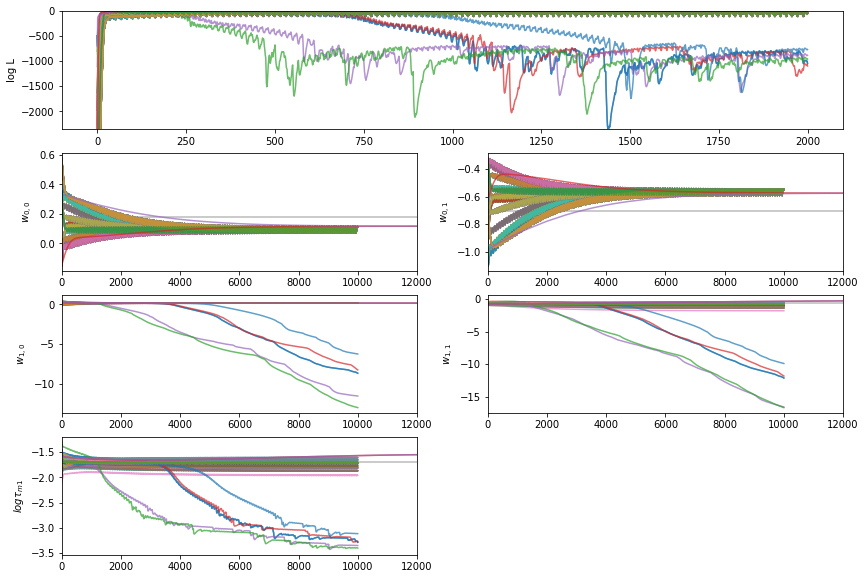

In [33]:
plots = sgd_coll.plot_evols()
for key, plot in plots.items():
    if key != 'logL':
        plot.axes.set_xlim((0, 12000))

## Database read

In [398]:
def flatten(container):
    for i in container:
        if isinstance(i, Iterable) and not isinstance(i, str):
            yield from flatten(i)
        else:
            yield i

def isiterable(value):
    return isinstance(value, Iterable) and not isinstance(value, str)

def param_match(paramset, name, value):
    def eq(a, b):
        if a == '*' or b == '*' or a == b:
            return True
        try:
            if np.isclose(a, b):
                return True
        except TypeError:
            pass
        return False
    
    names = name.split('.')
    paramsetvalue = paramset
    for nm in names:
        if nm in paramsetvalue:
            paramsetvalue = paramsetvalue[nm]
        else:
            return False
    
    #import pdb; pdb.set_trace()
    print(paramset.init_vals.w[0][0])
    if paramset.init_vals.w[0][0] == -0.147542:
        import pdb; pdb.set_trace()
        pass
    if not isiterable(value):
        assert(not isiterable(paramsetvalue))
        return eq(value, paramsetvalue)
    else:
        assert(isiterable(paramsetvalue))
        return all(eq(paramsetval, val)
                   for val, paramsetval in zip(flatten(value),
                                               flatten(paramsetvalue)))
        
def all_param_match(paramset, parameters):
    return all(param_match(record.parameters, name, value) 
               for name, value in parameters.items())

In [399]:
class RecordView:
    def __init__(self, db_file='.smt/records'):
        self.store = RecordStore(db_file)
        self.loaded = []
        
    def load(self, project, parameters=None, tags=None):
        if parameters is None:
            parameters = []
        for record in self.store.list(project, tags):
            if ( record not in self.loaded 
                 and all_param_match(record.parameters, parameters)):
                self.loaded.append(record)
    def unload(self, project, parameters=None, tags=None):
        if parameters is None:
            parameters = []
        for record in self.loaded:
            if tags is not None and not set(tags).issubset(record.tags):
                continue
            if all_param_match(record.parameters, parameters):
                self.loaded.remove(record)

In [427]:
record1, record2 = view.store.list('fsGIF')[0:2]
for i, test_record in enumerate(view.store.list('fsGIF')[0:10]):
    #print(test_record.diff)
    recdiff = record1.difference(test_record)
    print("Parameters differ ({} vs {}): {}."
          .format(0, i, recdiff.parameter_differences[1]))
#for i, test_record in enumerate(view.store.list('fsGIF')[0:10]):
#    recdiff = record2.difference(test_record)
#    print("Parameters differ ({} vs {}): {}."
#          .format(2, i, recdiff.parameters_differ))

Parameters differ (0 vs 0): {}.
Parameters differ (0 vs 1): {'init_vals': {'w': [[0.302129, -1.009037], [0.246381, -0.873329]]}, 'learning_rate': 0.0001, 'batch_size': 100}.
Parameters differ (0 vs 2): {}.
Parameters differ (0 vs 3): {'init_vals': {'w': [[0.302129, -1.009037], [0.246381, -0.873329]]}, 'learning_rate': 0.0001, 'batch_size': 100}.
Parameters differ (0 vs 4): {}.
Parameters differ (0 vs 5): {'init_vals': {'w': [[0.302129, -1.009037], [0.246381, -0.873329]]}, 'learning_rate': 0.0001, 'batch_size': 100}.
Parameters differ (0 vs 6): {}.
Parameters differ (0 vs 7): {'init_vals': {'w': [[0.302129, -1.009037], [0.246381, -0.873329]]}, 'learning_rate': 0.0001, 'batch_size': 100}.
Parameters differ (0 vs 8): {}.
Parameters differ (0 vs 9): {'init_vals': {'w': [[0.302129, -1.009037], [0.246381, -0.873329]]}, 'learning_rate': 0.0001, 'batch_size': 100}.


In [424]:
record1.difference(record2).parameter_differences

({'batch_size': 500,
  'init_vals': {'w': [[-0.147542, -0.627835], [0.246381, -0.873329]]},
  'learning_rate': 0.001},
 {'batch_size': 100,
  'init_vals': {'w': [[0.302129, -1.009037], [0.246381, -0.873329]]},
  'learning_rate': 0.0001})

## Hyper-param comparison

In [13]:
#from types import SimpleNamespace
#mgr.args = SimpleNamespace(resume=True)

In [15]:
mgr.params.init_vals = ParameterSet({
    'random': False,
    'format': 'cartesian',
    'variables': ['w', 'logτ_m', 'c'],
    'c': [10, 10],
    'w': [ [0.302129, -0.582306], [0.289588, -0.978509]],
    'logτ_m': [-1.69897, -1.447706]
})

In [16]:
sgd = gd_script.get_sgd(mgr, check_previous_runs=False)

2017-09-25 13:54:07,701 - fsgif - INFO - Precomputed activity data found.
2017-09-25 13:54:07,728 - fsgif - INFO - Precomputed input data found.
2017-09-25 13:54:11,059 - theano_shim - INFO - Clearing Theano updates
2017-09-25 13:54:11,064 - fsgif_model - INFO - Producing the likelihood graph.
2017-09-25 13:54:11,270 - fsgif_model - INFO - Likelihood graph complete
2017-09-25 13:54:11,275 - theano_shim - INFO - Clearing Theano updates
2017-09-25 13:54:11,285 - fsgif - INFO - Compiling adam optimizer...
2017-09-25 13:54:11,287 - theano_shim - INFO - Clearing Theano updates
2017-09-25 13:54:11,291 - sinn.optimize.gradient_descent - INFO - Producing the cost function theano graph
2017-09-25 13:54:11,292 - fsgif_model - INFO - Producing the likelihood graph.
2017-09-25 13:54:11,498 - fsgif_model - INFO - Likelihood graph complete
2017-09-25 13:54:11,499 - sinn.optimize.gradient_descent - INFO - Cost function graph complete.
2017-09-25 13:54:11,500 - sinn.optimize.gradient_descent - INFO - 

In [52]:
import theano
import theano.tensor as T

In [57]:
grad_graph = T.grad(sgd.get_cost_graph()[0], [sgd.get_param('w'), sgd.get_param('logτ_m')])

2017-09-25 14:36:27,811 - theano_shim - INFO - Clearing Theano updates
2017-09-25 14:36:27,820 - sinn.optimize.gradient_descent - INFO - Producing the cost function theano graph
2017-09-25 14:36:27,822 - fsgif_model - INFO - Producing the likelihood graph.
2017-09-25 14:36:28,134 - fsgif_model - INFO - Likelihood graph complete
2017-09-25 14:36:28,136 - sinn.optimize.gradient_descent - INFO - Cost function graph complete.
2017-09-25 14:36:28,137 - sinn.optimize.gradient_descent - INFO - Performing variable substitutions in Theano graph.
2017-09-25 14:36:28,147 - sinn.optimize.gradient_descent - INFO - Substitutions complete.


In [21]:
sgd.model.advance(sgd.burnin_idx)

2017-09-25 13:59:21,724 - fsgif_model - INFO - Compiling advance function.
2017-09-25 13:59:21,734 - theano_shim - INFO - Clearing Theano updates
2017-09-25 13:59:24,088 - theano_shim - INFO - Clearing Theano updates
2017-09-25 13:59:24,089 - fsgif_model - INFO - Done.


In [47]:
sgd.model.u._original_tidx.get_value()

array(10)

In [50]:
sgd.cost(sgd.burnin_idx, sgd.data_idxlen)

array(-23833411.636623845)

In [59]:
grad = theano.function([sgd.tidx_var, sgd.mbatch_var], grad_graph)

In [60]:
grad(sgd.step_i, sgd.mbatch_size)

[array([[-987.03056634, -437.62609575],
        [ 169.84165746,   44.81659158]]),
 array([ 948.94366801, -111.89432269])]

In [64]:
for i in range(800):
    sgd.step(0.1, cost_calc='full', cost_period=10)

2017-09-25 14:54:16,544 - sinn.optimize.gradient_descent - INFO - Iteration   850 – <log L> = -2920.36
2017-09-25 14:54:16,546 - sinn.optimize.gradient_descent - INFO -                   Last evaluated log L: -23829741.544954058


In [65]:
for i in range(10):
    sgd.step(0.1, cost_calc='full', cost_period=1)

2017-09-25 14:57:18,591 - sinn.optimize.gradient_descent - INFO - Iteration   860 – <log L> = -2929.94
2017-09-25 14:57:18,592 - sinn.optimize.gradient_descent - INFO -                   Last evaluated log L: -23829745.456521213


In [71]:
g1 = grad(sgd.step_i, sgd.mbatch_size)
g1

[array([[ 13.21247356,  11.23874965],
        [ 17.48014289,   7.19236149]]), array([-18.87017176, -21.38043091])]

In [72]:
g2 = grad(sgd.burnin_idx, sgd.data_idxlen)
g2

[array([[-2039.71674445, -1007.49651384],
        [ -955.20692261,  -332.91431995]]),
 array([ 2545.03658504,  1135.73676964])]

In [73]:
g2[0] / g1[0]

array([[-154.37811357,  -89.64489335],
       [ -54.64525826,  -46.28720627]])

In [75]:
g2[1] / g1[1]

array([-134.87087544,  -53.12038725])

In [83]:
gwlst = [grad(i, sgd.mbatch_size)[0] 
        for i in range(sgd.burnin_idx, 
                       sgd.data_idxlen-sgd.mbatch_size,
                       sgd.mbatch_size)]
gτlst = [grad(i, sgd.mbatch_size)[1] 
        for i in range(sgd.burnin_idx, 
                       sgd.data_idxlen-sgd.mbatch_size,
                       sgd.mbatch_size)]

In [82]:
np.array(glst).sum(axis=0)

array([[-2031.50067083,  -990.89968468],
       [   75.66944153,    32.41618389]])

In [84]:
np.array(gτlst).sum(axis=0)

array([ 2367.89272123,  -371.8209944 ])

In [90]:
start = 10
batch = 100
print(grad(start, batch)[0] + grad(start+batch, batch)[0])
print(grad(start, 2*batch)[0])

[[-1119.01551237  -513.29457614]
 [  -38.88217561   -12.62539749]]
[[-1140.20176184  -523.28590558]
 [  -69.28504242   -20.30715618]]


In [91]:
start = 10
batch = 500
print(grad(start, batch)[0] + grad(start+batch, batch)[0])
print(grad(start, 2*batch)[0])

[[-1778.58342946  -857.1669559 ]
 [ -130.70368184   -38.07018479]]
[[-1779.05840132  -857.42113187]
 [ -141.94691706   -42.62084528]]


In [93]:
start = 10
batch = 10
steps = 20
print(sum(grad(start+i*batch, batch)[0] for i in range(steps)))
print(grad(start, steps*batch)[0])

[[-369.7559985  -169.9651786 ]
 [  95.80934448   26.59666842]]
[[-1140.20176184  -523.28590558]
 [  -69.28504242   -20.30715618]]


In [95]:
start = 10
batch = 10
steps = 20
print(sum(sgd.cost(start+i*batch, batch) for i in range(steps)))
print(sgd.cost(start, steps*batch))

-595954.461086
-595923.4545387033


In [122]:
start = 10
batch = 2
steps = 2
l = [sgd.cost(start+i*batch, batch) for i in range(steps)]
if steps < 5:
    print(' + '.join([str(a) for a in l]) + ' = ', sum(l))
else:
    print(sum(l))
print(sgd.cost(start, steps*batch))

-5958.501177395199 + -5957.3720103631495 =  -11915.8731878
-11915.92206039182


In [142]:
start = 10
batch = 1
steps = 2
l = [logL(start+i*batch, batch) for i in range(steps)]
if steps < 5:
    print(' + '.join([str(a) for a in l]) + ' = ', sum(l))
else:
    print(sum(l))
print(logL(start, steps*batch))

DEBUG - n __str__ = [3 2]
DEBUG - nbar __str__ = [ 7.38644464  1.40727619]
DEBUG - n __str__ = [10  2]
DEBUG - nbar __str__ = [ 7.74126877  1.3966994 ]
-2979.674374414057 + -2978.8583393520853 =  -5958.53271377
DEBUG - n __str__ = [3 2]
DEBUG - nbar __str__ = [ 7.38644464  1.40727619]
DEBUG - n __str__ = [10  2]
DEBUG - nbar __str__ = [ 7.74294586  1.39357945]
-5958.533588760097


In [137]:
a = np.array([-2979.674374414057, -5958.533588760097, 
              -8937.400031724264, -11915.907123076639])
a[1:] - a[:-1]

array([-2978.85921435, -2978.86644296, -2978.50709135])

In [138]:
a = np.array([[-2979.674374414057, -5958.533588760097],
              [-2978.8709021955606, -5957.374977348616]])
a[...,1:] - a[...,:-1]

array([[-2978.85921435],
       [-2978.50407515]])

In [115]:
sgd.model.nbar._cur_tidx.get_value()

array(-1)

In [254]:
def logLgraph(start, batch_size):

    self = sgd.model
    ####################
    # Some hacks to get around current limitations

    self.remove_other_histories()

    # End hacks
    #####################

    startidx = self.get_t_idx(start)
    stopidx = startidx + batch_size
    N = self.params.N

    # Windowed test
    #windowlen = 5
    #stopidx -= windowlen

    def logLstep(tidx, *args):
        statevar_updates, input_vars, output_vars = symbolic_update(tidx, args[2:])
            # FIXME: make this args[1:] once n is in state variables
        nbar = shim.print(output_vars[self.nbar], 'nbar')
        updates = shim.get_updates()
        p = sinn.clip_probabilities(nbar / self.params.N)
        n = shim.print(shim.cast(self.n[tidx+self.n.t0idx], 'int32'), 'n')
        #n = shim.cast(self.n[tidx+self.n.t0idx-windowlen:tidx+self.n.t0idx].sum(axis=0), 'int32')

        cum_logL = args[0] + ( -shim.gammaln(n+1) - shim.gammaln(N-n+1)
                               + n*shim.log(p)
                               + (N-n)*shim.log(1-p)
                              ).sum()

        return [cum_logL] + [n] + list(statevar_updates.values()), {}
        # FIXME: Remove [n] once it is included in state vars
        # return [cum_logL], shim.get_updates()

    logger.info("Producing the likelihood graph.")

    # Create the outputs_info list
    # First element is the loglikelihood, subsequent are aligned with input_vars
    outputs_info = [shim.cast(0, sinn.config.floatX)]

    # FIXME: Remove once 'n' is in state variables
    outputs_info.append( shim.cast_int32(self.n._data[startidx + self.n.t0idx - 1]) )
    #outputs_info.append( self.n._data[startidx + self.n.t0idx - 1] )


    for hist in self.statehists:
        outputs_info.append( hist._data[startidx + hist.t0idx - 1] )
        # HACK !!
        # if hist.name == 'v':
        #     outputs_info[-1] = shim.getT().unbroadcast(outputs_info[-1], 1)
        # elif hist.name == 'z':
        #     outputs_info[-1] = shim.getT().unbroadcast(outputs_info[-1], 0)
    if batch_size == 1:
        # No need for scan
        outputs, upds = logLstep(start, *outputs_info)
        outputs[0] = [outputs[0]]

    else:
        # FIXME np.float64 -> shim.floatX or sinn.floatX
        outputs, upds = shim.gettheano().scan(logLstep,
                                              sequences = shim.getT().arange(startidx, stopidx),
                                              outputs_info = outputs_info)
                                              #outputs_info = np.float64(0))
        # HACK Since we are still using shared variables for data
        #for hist, new_data in outputs[1:]:
        #    hist.update(slice(startidx+hist.t0idx, stopidx+hist.t0idx),
        #                new_data)

        self.apply_updates(upds)
            # Applying updates is essential to remove the iteration variable
            # scan introduces from the shim updates dictionary

    logger.info("Likelihood graph complete")

    return outputs[0][-1], outputs[1:], upds

In [222]:
curtidx_var = shim.getT().lscalar()
stopidx_var = shim.getT().lscalar()
sgd.model.remove_other_histories()  # HACK
sgd.model.clear_unlocked_histories()
sgd.model.theano_reset()

def onestep(tidx, *args):
    statevar_upds, input_vars, output_vars = symbolic_update(tidx, args)
    return list(statevar_upds.values()), {}

outputs_info = []
for hist in sgd.model.statehists:
    outputs_info.append( hist._data[curtidx_var + hist.t0idx])

outputs, upds = shim.gettheano().scan(onestep,
                                      sequences = shim.getT().arange(curtidx_var+1, stopidx_var),
                                      outputs_info = outputs_info)
sgd.model.apply_updates(upds)
    # Applying updates ensures we remove the iteration variable
    # scan introduces from the shim updates dictionary

_advance = theano.function([curtidx_var, stopidx_var],
                                             outputs)

sgd.model.theano_reset()

def advance(curtidx, stopidx):
    if curtidx+1 < stopidx:
        newvals = _advance(curtidx, stopidx)
        # HACK: We change the history directly to avoid dealing with updates
        for hist, newval in zip(sgd.model.statehists, newvals):
            valslice = slice(curtidx+1+hist.t0idx, stopidx+hist.t0idx)

            data = hist._original_data.get_value(borrow=True)
            data[valslice] = newval
            hist._original_data.set_value(data, borrow=True)
            hist._data = hist._original_data

            hist._original_tidx.set_value( valslice.stop - 1 )
            hist._cur_tidx = hist._original_tidx


2017-09-26 13:50:11,609 - theano_shim - INFO - Clearing Theano updates
2017-09-26 13:50:16,347 - theano_shim - INFO - Clearing Theano updates


In [258]:
def symbolic_update(tidx, statevars):
    """
    Temorary fix to get symbolic updates. Eventually sinn should
    be able to do this itself.
    """

    self = sgd.model
    
    curstate = self.State(*statevars)

    λfree0 = curstate.λfree
    λ0 = curstate.λ
    #Pfree0 = statevars[2]
    #P_λ0 = statevars[3]
    g0 = curstate.g
    h0 = curstate.h
    u0 = curstate.u
    v0 = curstate.v
    m0 = curstate.m
    x0 = curstate.x
    y0 = curstate.y
    z0 = curstate.z

    # shared constants
    tidx_n = shim.print(tidx, 'tidx') + self.n.t0idx

    # yt
    red_factor = shim.exp(-self.y.dt/self.params.τ_s)
    yt = self.A_Δ[tidx+self.A_Δ.t0idx] + (y0 - self.A_Δ[tidx+self.A_Δ.t0idx]) * red_factor
    yt = yt

    # htot
    τ_mα = self.params.τ_m.flatten()[:,np.newaxis]
    red_factor_τm = shim.exp(-self.h_tot.dt/self.params.τ_m)
    red_factor_τmT = shim.exp(-self.h_tot.dt/τ_mα)
    red_factor_τs = shim.exp(-self.h_tot.dt/self.params.τ_s)
    h_tot = ( self.params.u_rest + self.params.R*self.I_ext[tidx+self.I_ext.t0idx] * (1 - red_factor_τm)
             + ( τ_mα * (self.params.p * self.params.w) * self.params.N
                   * (self.A_Δ[tidx+self.A_Δ.t0idx]
                      + ( ( self.params.τ_s * red_factor_τs * ( yt - self.A_Δ[tidx+self.A_Δ.t0idx] )
                            - red_factor_τmT * (self.params.τ_s * yt - τ_mα * self.A_Δ[tidx+self.A_Δ.t0idx]) )
                          / (self.params.τ_s - τ_mα) ) )
               ).sum(axis=-1) )
    h_tot = shim.print(h_tot, 'h_tot')

    # ht
    red_factor = shim.exp(-self.h.dt/self.params.τ_m.flatten() )
    ht = ( (shim.print(h0, 'h0') - self.params.u_rest) 
          * red_factor + h_tot )
    ht = shim.print(ht, 'ht')

    # ut
    red_factor = shim.exp(-self.u.dt/self.params.τ_m).flatten()[np.newaxis, ...]
    ut = shim.concatenate(
        ( self.params.u_r[..., np.newaxis, :],
          ((u0[:-1] - self.params.u_rest[np.newaxis, ...]) * red_factor + h_tot[np.newaxis,...]) ),
        axis=-2)

    # gt
    red_factor = shim.exp(- self.g.dt/self.params.τ_θ)
    gt = ( g0 * red_factor
             + (1 - red_factor) * self.n._data[tidx_n-self.K] / (self.params.N * self.g.dt)
            ).flatten()

    # varθfree
    red_factor = (self.params.J_θ * shim.exp(-self.memory_time/self.params.τ_θ)).flatten()
    varθfree =  self.params.u_th + red_factor * gt

    # varθ
    K = self.u.shape[0]
    varθref = ( shim.cumsum(self.n._data[tidx_n-K:tidx_n] * self.θtilde_dis._data[:K][...,::-1,:],
                            axis=-2)
                          - self.n._data[tidx_n-K:tidx_n] * self.θtilde_dis._data[:K][...,::-1,:])[...,::-1,:]
    varθ = self.θ_dis._data[:K] + varθfree + varθref

    # λt
    λt = self.f(ut - varθ) * self.ref_mask

    # λfree
    λfreet = self.f(ht - varθfree[0])

    # Pfreet
    Pfreet = 1 - shim.exp(-0.5 * (λfree0 + λfreet) * self.λfree.dt )

    # P_λt
    λprev = shim.concatenate(
        ( shim.zeros((1,) + self.λ.shape[1:]),
          λ0[:-1] ) )
    P_λ_tmp = 0.5 * (λt + λprev) * self.P_λ.dt
    P_λt = shim.switch(P_λ_tmp <= 0.01,
                       P_λ_tmp,
                       1 - shim.exp(-P_λ_tmp))
    # mt
    mt = shim.concatenate(
        ( self.n._data[tidx_n-1][np.newaxis,:], ((1 - P_λt[1:]) * m0[:-1]) ),
        axis=-2 )

    # X
    X = mt.sum(axis=-2)

    # xt
    xt = ( (1 - Pfreet) * x0 + mt[-1] )

    # vt
    vt = shim.concatenate(
        ( shim.zeros( (1,) + self.v.shape[1:] , dtype=sinn.config.floatX),
          (1 - P_λt[1:])**2 * v0[:-1] + P_λt[1:] * m0[:-1] ),
        axis=-2)

    # zt
    zt = ( (1 - Pfreet)**2 * z0  +  Pfreet*x0  + vt[0] )

    # W
    Wref_mask = self.ref_mask[:self.m.shape[0],:]
    W = (P_λt * mt * Wref_mask).sum(axis=-2)

    # Y
    Y = (P_λt * v0).sum(axis=-2)

    # Z
    Z = v0.sum(axis=-2)

    # P_Λ
    P_Λ = shim.switch( Z + z0 > 0,
                       ( (Y + Pfreet*z0)
                         / (shim.abs(Z + z0) + sinn.config.abs_tolerance) ),
                       0 )

    # nbar
    nbar = ( W + Pfreet * xt + P_Λ * (self.params.N - X - xt) )

    newstate = self.State(
        h = ht,
        u = ut,
        λ = λt,
        λfree = λfreet,
        g = gt,
        m = mt,
        v = vt,
        x = xt,
        y = yt,
        z = zt
        )

    updates = OrderedDict( (getattr(curstate, key), getattr(newstate, key))
                           for key in self.State._fields )

    # TODO: use the key string itself
    input_vars = OrderedDict( (getattr(self, key), getattr(curstate, key))
                              for key in self.State._fields )

    # Output variables contain updates to the state variables, as well as
    # whatever other quantities we want to compute
    output_vars = OrderedDict( (getattr(self, key), getattr(newstate, key))
                               for key in self.State._fields )
    output_vars[self.nbar] = nbar

    return updates, input_vars, output_vars


In [259]:
logL = theano.function([sgd.tidx_var, sgd.mbatch_var],
                       logLgraph(sgd.tidx_var, sgd.mbatch_var)[0])

2017-09-26 15:06:30,930 - fsgif - INFO - Producing the likelihood graph.
2017-09-26 15:06:31,225 - fsgif - INFO - Likelihood graph complete


In [284]:
start = 7880
batch = 1
steps = 5
l = [logL(start+i*batch, batch) for i in range(steps)]
if steps < 3:
    print(' + '.join([str(a) for a in l]) + ' = ', sum(l))
else:
    print(sum(l))
print("\n")
print(logL(start, steps*batch))

DEBUG - n __str__ = [3 1]
DEBUG - h_tot __str__ = [ 20.17343192  20.33914908]
DEBUG - tidx __str__ = 7880
DEBUG - h0 __str__ = [ 20.23110748  18.86582602]
DEBUG - ht __str__ = [ 20.27626693  18.88433834]
DEBUG - nbar __str__ = [ 3.60010026  0.84236391]
DEBUG - n __str__ = [5 1]
DEBUG - h_tot __str__ = [ 20.11012297  20.26774879]
DEBUG - tidx __str__ = 7881
DEBUG - h0 __str__ = [ 20.27654871  18.89331725]
DEBUG - ht __str__ = [ 20.25618302  18.83966925]
DEBUG - nbar __str__ = [ 3.60999859  0.84557913]
DEBUG - n __str__ = [6 2]
DEBUG - h_tot __str__ = [ 20.27244005  20.35288483]
DEBUG - tidx __str__ = 7882
DEBUG - h0 __str__ = [ 20.25648041  18.84880338]
DEBUG - ht __str__ = [ 20.39941054  18.88152206]
DEBUG - nbar __str__ = [ 3.63142386  0.85000661]
DEBUG - n __str__ = [3 1]
DEBUG - h_tot __str__ = [ 20.13524953  20.41780514]
DEBUG - tidx __str__ = 7883
DEBUG - h0 __str__ = [ 20.39993209  18.89235061]
DEBUG - ht __str__ = [ 20.39867548  18.98878569]
DEBUG - nbar __str__ = [ 3.64595524  

In [270]:
def ht(h0, h_tot):
    self = sgd.model
    red_factor = shim.exp(-self.h.dt/self.params.τ_m.get_value().flatten() )
    return ( (h0 - self.params.u_rest.get_value()) * red_factor + h_tot )

In [274]:
print(ht(26.80030844, 20.61064736))
print(ht(26.80030844, 20.53696906))
print(ht(26.80180205, 20.38119651))

[ 26.96229962  26.87096228]
[ 26.88862132  26.79728398]
[ 26.73426954  26.64296374]


In [237]:
start = 100

In [235]:
sgd.model.h._data.get_value()[start+sgd.model.h.t0idx:start+4+sgd.model.h.t0idx]

array([[ 21.18375324,  20.03324596],
       [ 21.40996256,  20.06473576],
       [ 21.74808556,  20.1633551 ],
       [ 22.00358028,  20.28606004]])

In [238]:
sgd.model.h._data.get_value()[start+sgd.model.h.t0idx:start+4+sgd.model.h.t0idx]

array([[ 26.9612444 ,  22.06982674],
       [ 27.04170834,  22.03963899],
       [ 27.01053626,  22.04945998],
       [ 26.97675282,  22.08822698]])

In [255]:
sgd.model.h_tot._data.get_value()[start+sgd.model.h.t0idx:start+4+sgd.model.h.t0idx]

array([[ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.]])

In [283]:
np.nonzero(sgd.model.h._data.get_value() == 0)

(array([ 7930,  7930,  7931, ..., 19998, 19999, 19999]),
 array([0, 1, 0, ..., 1, 0, 1]))

In [281]:
advance(50, 105)

DEBUG - h0 __str__ = [ 24.95383486  21.62219309]
DEBUG - ht __str__ = [ 24.86704093  21.61065907]
DEBUG - tidx __str__ = 51
DEBUG - h0 __str__ = [ 24.86704093  21.61065907]
DEBUG - ht __str__ = [ 24.84014519  21.5256977 ]
DEBUG - tidx __str__ = 52
DEBUG - h0 __str__ = [ 24.84014519  21.5256977 ]
DEBUG - ht __str__ = [ 24.91175127  21.57314489]
DEBUG - tidx __str__ = 53
DEBUG - h0 __str__ = [ 24.91175127  21.57314489]
DEBUG - ht __str__ = [ 25.17697726  21.61356398]
DEBUG - tidx __str__ = 54
DEBUG - h0 __str__ = [ 25.17697726  21.61356398]
DEBUG - ht __str__ = [ 25.31068772  21.71776839]
DEBUG - tidx __str__ = 55
DEBUG - h0 __str__ = [ 25.31068772  21.71776839]
DEBUG - ht __str__ = [ 25.43529945  21.75484918]
DEBUG - tidx __str__ = 56
DEBUG - h0 __str__ = [ 25.43529945  21.75484918]
DEBUG - ht __str__ = [ 25.45537599  21.76286162]
DEBUG - tidx __str__ = 57
DEBUG - h0 __str__ = [ 25.45537599  21.76286162]
DEBUG - ht __str__ = [ 25.51989734  21.80100729]
DEBUG - tidx __str__ = 58
DEBUG - 

In [232]:
sgd.model.h.t0idx

1